# NLP Assignment 1 (40% of grade): Sentiment Analysis from Tweets

This coursework will involve you implementing functions for a text classifier, which you will train to identify the **sentiment expressed in a text** in a dataset of approx. 27,000 entries, which will be split into a 80%/20% training/test split.

In this template you are given the basis for that implementation, though some of the functions are missing, which you have to fill in.

Follow the instructions file **NLP_Assignment_1_Instructions.pdf** for details of each question - the outline of what needs to be achieved for each question is as below.

You must submit all **ipython notebooks and extra resources you need to run the code if you've added them** in the code submission, and a **2 page report (pdf)** in the report submission on QMPlus where you report your methods and findings according to the instructions file for each question.

In [71]:
!pip install nltk

In [72]:
import csv                              
from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support # to report on precision and recall
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer


In [73]:
def load_data(path):
    """Load data from a tab-separated file and append it to raw_data."""
    with open(path) as f:
        reader = csv.reader(f, delimiter='\t')
        for line in reader:
            if line[0] == "Id":  # skip header
                continue
            (label, text) = parse_data_line(line)
            raw_data.append((text, label))

def split_and_preprocess_data(percentage):
    """Split the data between train_data and test_data according to the percentage
    and performs the preprocessing."""
    num_samples = len(raw_data)
    num_training_samples = int((percentage * num_samples))
    for (text, label) in raw_data[:num_training_samples]:
        train_data.append((to_feature_vector(pre_process(text)),label))
    for (text, label) in raw_data[num_training_samples:]:
        test_data.append((to_feature_vector(pre_process(text)),label))

# Question 1: Input and Basic preprocessing (10 marks)

In [74]:
def parse_data_line(data_line):
    if len(data_line) >= 3:
        return (data_line[1], data_line[2])


# Unit testing this function
# Test Case 1 - Positive Test Case
test_case_1 = parse_data_line(['1234ID', 'positive', 'London is a good city'])
print(test_case_1)
assert test_case_1 == ('positive', 'London is a good city')

# Test Case 2 - Negative Test (when data_line does not have sufficient elements)
'''
This illustrates that the system will not process any line from the file 
that does not have at least three tab-separated data. Also, I am looking at the pattern
of the file I am assuming the second column will be labeled and the third column will be tested.
'''
test_case_2 = parse_data_line(['1234ID', 'London is a good city'])
print(test_case_2)
assert test_case_2 == None



('positive', 'London is a good city')
None


In [75]:
import regex as re

# Input: a string of one statement
def pre_process(text):
    '''
    After doing a sentence segmentation, we want to extract tokens from a sentence.
    This method takes a string (sentence) and returns all the tokens. Tokens are
    nothing but words.
    '''

    # We are separating any punctuation symbols from the end and the beginning.
    # This will be helpful in subsequent filtering of tokens where we do/don't require punctuation as per our need.
    text = re.sub(r"(\w)([.,;:!?'\"”\)])", r"\1 \2", text)
    text = re.sub(r"([.,;:!?'\"“\(\)])(\w)", r"\1 \2", text)

    # Now, we can just split the sentence by whitespace.
    tokens = re.split(r"\s+",text)
    
    # Normalisation - transform all the tokens in lowercase because different cases 
    # might be inferred as a different feature that we don't want
    tokens = [t.lower() for t in tokens]

    # NOTE: More optimization is done in the second Notebook file wrt Question 5
    return tokens


# Unit testing this function
# Test Case 1 - Positive Test Case
processed_text = pre_process("I love India, and it is very beautiful country.")
print(processed_text)
assert processed_text == ['i', 'love', 'india', ',', 'and', 'it', 'is', 'very', 'beautiful', 'country', '.']

# Test Case 2 - Positive Test Case (repeated words)
processed_text = pre_process("I love India, and India is very beautiful country.")
print(processed_text)
assert processed_text == ['i', 'love', 'india', ',', 'and', 'india', 'is', 'very', 'beautiful', 'country', '.']

# NOTE: - This method is optimized further in NLP_Assignment_2.ipynb


['i', 'love', 'india', ',', 'and', 'it', 'is', 'very', 'beautiful', 'country', '.']
['i', 'love', 'india', ',', 'and', 'india', 'is', 'very', 'beautiful', 'country', '.']


# Question 2: Basic Feature Extraction (20 marks)

In [76]:
from collections import Counter

global_feature_dict = Counter() # bag of words

def to_feature_vector(tokens):

    """
    Convert tokens to a feature vector.
    Parameters:
    - string tokens of a sentence.
    Returns:
    - feature_vector: Python dictionary with tokens as keys and corresponding weights as values.
    """

    # This will count the frequency of the words
    feature_counter = Counter(tokens)

    # Updating the global_feature_dict, which represents the bag of words and their occurrence. 
    global_feature_dict.update(feature_counter.keys())

    # Using binary feature value ie will give weight as 1 for the token present
    feature_vector = {feature: 1 for feature in feature_counter}
    return feature_vector

# NOTE: - This method is optimized further in NLP_Assignment_2.ipynb

# Unit testing this function
# Test Case 1 - Positive Test Case
token = pre_process("I study in Queen mary university of London")
test_case_1_result = to_feature_vector(token) 
print(test_case_1_result)
assert test_case_1_result == {'i': 1, 'study': 1, 'in': 1, 'queen': 1, 'mary': 1, 'university': 1, 'of': 1, 'london': 1}
assert global_feature_dict == {'i': 1, 'study': 1, 'in': 1, 'queen': 1, 'mary': 1, 'university': 1, 'of': 1, 'london': 1}

# Test Case 1 - Positive Test Case
token = pre_process("NLP is my favorite subject")
test_case_2_result = to_feature_vector(token) 
print(test_case_1_result)
assert test_case_2_result == {'nlp': 1, 'is': 1, 'my': 1, 'favorite': 1, 'subject': 1}
assert global_feature_dict == {'i': 1, 'study': 1, 'in': 1, 'queen': 1, 'mary': 1, 'university': 1, 'of': 1, 'london': 1, 'nlp': 1, 'is': 1, 'my': 1, 'favorite': 1, 'subject': 1}


{'i': 1, 'study': 1, 'in': 1, 'queen': 1, 'mary': 1, 'university': 1, 'of': 1, 'london': 1}
{'i': 1, 'study': 1, 'in': 1, 'queen': 1, 'mary': 1, 'university': 1, 'of': 1, 'london': 1}


In [77]:
# TRAINING AND VALIDATING OUR CLASSIFIER

def train_classifier(data):
    # print("Training Classifier...")
    pipeline =  Pipeline([('svc', LinearSVC(dual=True))])
    return SklearnClassifier(pipeline).train(data)


# Question 3: Cross-validation (20 marks)

In [78]:
# PREDICTING LABELS GIVEN A CLASSIFIER

def predict_labels(samples, classifier):
    """Assuming preprocessed samples, return their predicted labels from the classifier model."""
    return classifier.classify_many(samples)

def predict_label_from_raw(sample, classifier):
    """Assuming raw text, return its predicted label from the classifier model."""
    return classifier.classify(to_feature_vector(pre_process(sample)))

In [79]:
#solution
from sklearn.metrics import classification_report
import numpy as np

cv_results = {}
label_for_train_data = []
prediction_label = []
def cross_validate(dataset, folds):
    results = []
    fold_size = int(len(dataset)/folds) + 1

    for i in range(0,len(dataset),int(fold_size)):
        print("Fold start on items %d - %d" % (i, i+fold_size))

        # test and train dataset preparation
        test_data_fold = dataset[i:i + fold_size]
        train_data_fold = dataset[:i] + dataset[i + fold_size:]

        count_of_positive_label = [label for text, label in train_data_fold if label == 'positive']
        count_of_negative_label = [label for text, label in train_data_fold if label == 'negative']
        
        # features (X) and labels (y) from the training dataset and training of the classifier model
        feature_for_train_data = [train_text for train_text, train_label in train_data_fold]
        label_for_train_data = [train_label for train_text, train_label in train_data_fold]
        classifier = train_classifier(list(zip(feature_for_train_data, label_for_train_data)))

        # features (X) and labels (y) from the testing dataset and predicting labels using the classifier model
        feature_for_test_data = [test_text for test_text, test_label in test_data_fold]
        label_for_test_data = [test_label for test_text, test_label in test_data_fold]
        prediction_label = [predict_labels(text, classifier) for text in feature_for_test_data]

        '''
        Once we have predicted the labels for the test data, we can measure the drift between the labels given for the 
        test data and the labels predicted for the test data.

        As given in the question we will be calculating precision, recall, f1 score, and accuracy
        '''
        precision_metric, recall_metric, f1_metric, _ = precision_recall_fscore_support(label_for_test_data, prediction_label, average='weighted') # evaluate
        accuracy_metric = accuracy_score(label_for_test_data, prediction_label)

        # Store results for this fold
        results.append({
            'precision': precision_metric,
            'recall': recall_metric,
            'f1': f1_metric,
            'accuracy': accuracy_metric
        })

    cv_results = {
            'precision': np.mean([d["precision"] for d in results]),
            'recall': np.mean([d["recall"] for d in results]),
            'f1': np.mean([d["f1"] for d in results]),
            'accuracy': np.mean([d["accuracy"] for d in results])}
    return cv_results


In [80]:
# MAIN
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# loading reviews
# initialize global lists that will be appended to by the methods below
raw_data = []          # the filtered data from the dataset file
train_data = []        # the pre-processed training data as a percentage of the total dataset
test_data = []         # the pre-processed test data as a percentage of the total dataset

# references to the data files
data_file_path = 'sentiment-dataset.tsv'

# Do the actual stuff (i.e. call the functions we've made)
# We parse the dataset and put it in a raw data list
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing the dataset...",sep='\n')

load_data(data_file_path)

# We split the raw dataset into a set of training data and a set of test data (80/20)
# You do the cross validation on the 80% (training data)
# We print the number of training samples and the number of features before the split
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing training and test data...",sep='\n')

split_and_preprocess_data(0.8)

# We print the number of training samples and the number of features after the split
print("After split, %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Training Samples: ", len(train_data), "Features: ", len(global_feature_dict), sep='\t')



Now 0 rawData, 0 trainData, 0 testData
Preparing the dataset...
Now 33540 rawData, 0 trainData, 0 testData
Preparing training and test data...
After split, 33540 rawData, 26832 trainData, 6708 testData	Training Samples: 	26832	Features: 	64641


In [81]:
cross_validate(train_data, 10)  # will work and output overall performance of p, r, f-score when cv implemented

Fold start on items 0 - 2684
Fold start on items 2684 - 5368
Fold start on items 5368 - 8052
Fold start on items 8052 - 10736
Fold start on items 10736 - 13420
Fold start on items 13420 - 16104
Fold start on items 16104 - 18788
Fold start on items 18788 - 21472
Fold start on items 21472 - 24156
Fold start on items 24156 - 26840


{'precision': 0.8470426013416796,
 'recall': 0.848318441342039,
 'f1': 0.8473022431744743,
 'accuracy': 0.848318441342039}

# Question 4: Error Analysis (20 marks)

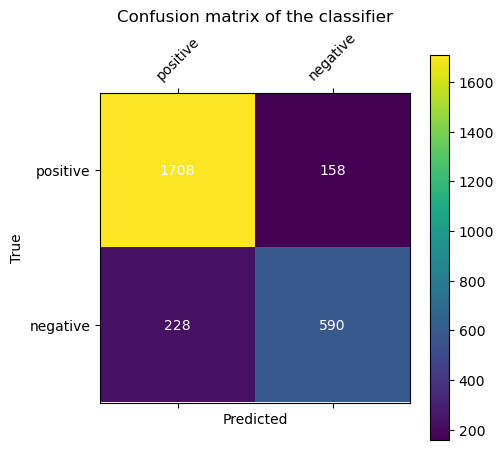

Recall of negative class = 0.7212713936430318, Precesion of negative class = 0.7887700534759359
Recall of positive class = 0.9153269024651661, Precesion of positive class = 0.8822314049586777
**** Writing FALSE POSITIVE and FALSE NEGATIVE detection (ref: fp_fn_initially.csv)****


In [82]:
import csv
from sklearn import metrics
import matplotlib.pyplot as plt

# a function to make the confusion matrix readable and pretty
def confusion_matrix_heatmap(y_test, preds, labels):
    """Function to plot a confusion matrix"""
    # pass labels to the confusion matrix function to ensure right order
    # cm = metrics.confusion_matrix(y_test, preds, labels)
    cm = metrics.confusion_matrix(y_test, preds, labels=labels)
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')

    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!
    plt.show()

    return cm

def write_csv(file_name):
    '''
    This function calculates and writes False Positive and False Negative cases onto a CSV file.

    Parameter:
        Takes a file name as input
    '''
    cases_for_fp_fn = []        
    for text, expected, actual in zip(text_for_test_data, label_for_test_data, prediction_label):
        if expected == actual:
            continue
            
        cases_for_fp_fn.append([expected, actual, text])
    
    with open(file_name, mode='w', newline='') as file:
        writer = csv.writer(file)
        
        # Write each row in the data list
        for r in cases_for_fp_fn:
            writer.writerow(r)


'''
To look at the performance of the classes we will use the above function and
pass labels for the test data and predicted labels to see what the balance of 
false positives and false negatives for the positive and negative labels. 
'''

'''
Fetching a single fold data to carry out an error analysis for the first part 
of 10-fold data.
'''
fold_size = int(len(train_data)/10) + 1
first_fold_test_data = train_data[:fold_size]
first_fold_train_data = train_data[fold_size:]

feature_for_train_data = [text for text, label in first_fold_train_data]
label_for_train_data = [label for text, label in first_fold_train_data]
classifier = train_classifier(list(zip(feature_for_train_data, label_for_train_data)))

text_for_test_data = [text for text, label in first_fold_test_data]
label_for_test_data = [label for text, label in first_fold_test_data]
prediction_label = [classifier.classify(text) for text in text_for_test_data]

# Invoking confusion_matrix_heatmap for the first part of 10-fold data
cm_data = confusion_matrix_heatmap(label_for_test_data, prediction_label, labels=['positive', 'negative'])

# Values for confusion metrics
tp = cm_data[0][0]
fn = cm_data[0][1]
fp = cm_data[1][0]
tn = cm_data[1][1]

# Calculating recall/sensitivity for negative and positive
recall_of_negative = tn / (tn + fp)
recall_of_positive = tp / (tp + fn)

# Calculating precision for negative and positive
prec_of_negative = tn / (tn + fn) 
prec_of_positive = tp / (tp + fp) 

print('Recall of negative class = {}, Precesion of negative class = {}'.format(recall_of_negative, prec_of_negative))
print('Recall of positive class = {}, Precesion of positive class = {}'.format(recall_of_positive, prec_of_positive))

print('**** Writing FALSE POSITIVE and FALSE NEGATIVE detection (ref: fp_fn_initially.csv)****')
write_csv("fp_fn_initially.csv") 


# Questions 5: Optimising pre-processing and feature extraction (30 marks)
Ref- NLP_Assignment_2.ipynb

**Note:** it is advisable to implement question 5 in a separate notebook where you further develop the pre-processing and feature extraction functions you implemented above.

({'tomorrow': 1, 'we': 1, "'": 1, 'll': 1, 'release': 1, 'our': 1, '58th': 1, 'episode': 1, 'of': 1, '#hsonair': 1, 'profiling': 1, 'very': 1, 'own': 1, '@alissadossantos': 1, '!': 1, 'talk': 1, 'about': 1, 'storytelling': 1, 'and': 1, 'beyonce': 1}, 'positive')
(0.8525944778240879, 0.8537567084078712, 0.8529661074716973, None)
Done training!
Precision: 0.852594
Recall: 0.853757
F Score:0.852966


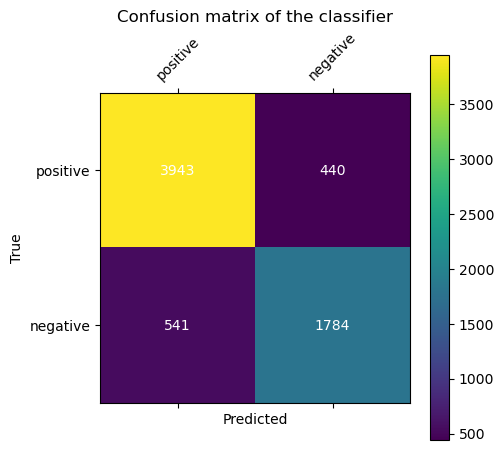

In [83]:
# Finally, check the accuracy of your classifier by training on all the training data
# and testing on the test set
# Will only work once all functions are complete
functions_complete = True  # set to True once you're happy with your methods for cross-val
if functions_complete:
    print(test_data[0])   # have a look at the first test data instance
    classifier = train_classifier(train_data)  # train the classifier
    test_true = [t[1] for t in test_data]   # get the ground-truth labels from the data
    test_pred = predict_labels([x[0] for x in test_data], classifier)  # classify the test data to get predicted labels
    final_scores = precision_recall_fscore_support(test_true, test_pred, average='weighted') # evaluate
    print(final_scores)
    print("Done training!")
    print("Precision: %f\nRecall: %f\nF Score:%f" % final_scores[:3])
    confusion_matrix_heatmap(test_true, test_pred, labels=['positive', 'negative'])
